In [1]:
library(miloR)
library(igraph)
library(BiocParallel)
library(SingleCellExperiment)
library(Matrix)
library(dplyr)
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal')

Loading required package: edgeR

Loading required package: limma


Attaching package: ‘igraph’


The following object is masked from ‘package:miloR’:

    graph


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    c

In [2]:
mylo <- readRDS('h5ad/df.fil3_gex_bcells_no_CLL_vdj_trimmed_no_nas_milo.RDS')
metadata = data.frame(colData(mylo))

In [3]:
# metadata$case_control <- ordered(factor(metadata$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY')))
metadata$case_control <- factor(metadata$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
metadata$WHO_temp_severity <- factor(metadata$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
metadata$WHO_temp_severity_group <- factor(metadata$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
metadata$WHO_severity_group <- factor(metadata$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
metadata$grouped_temp_severity <- ifelse(metadata$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
metadata$grouped_severity <- ifelse(metadata$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
metadata$age_scaled <- scale(metadata$calc_age) # scale age
metadata$ethnicity = factor(metadata$ethnicity)
metadata$sex = factor(metadata$sex)
metadata$centre = factor(metadata$centre)

In [4]:
# remove 
metadata <- distinct(metadata[, c('sample_id', 'individual_id', 'case_control', 'WHO_temp_severity', 'WHO_temp_severity_group', 'WHO_severity_group', 'grouped_temp_severity', 'grouped_severity', 'sex', 'ethnicity', 'age_scaled', 'centre', 'time_from_infection')], .keep_all = TRUE)
metadata

,sample_id,individual_id,case_control,WHO_temp_severity,WHO_temp_severity_group,WHO_severity_group,grouped_temp_severity,grouped_severity,sex,ethnicity,age_scaled,centre,time_from_infection
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>,"<dbl[,1]>",<fct>,<dbl>
UK-CIC10689738+UK-CIC10690026_AACACGTGTTGGTGGA-1,C123_0505,C123,POSITIVE,moderate,mild_moderate,severe_critical,mild_moderate,severe_critical,M,asian,0.30051451,NCL,18
UK-CIC10689740+UK-CIC10690028_AAACGGGAGCTCCTCT-1,C42_1504,C42,POSITIVE,moderate,mild_moderate,mild_moderate,mild_moderate,mild_moderate,M,white,-1.21957771,NCL,2
UK-CIC10689740+UK-CIC10690028_AAAGCAATCAACACAC-1,C40_0105,C40,POSITIVE,critical,severe_critical,severe_critical,severe_critical,severe_critical,M,black,-0.22567126,NCL,18
UK-CIC10689742+UK-CIC10690030_AAACCTGGTCAAAGCG-1,C124_0105,C124,POSITIVE,mild,mild_moderate,mild_moderate,mild_moderate,mild_moderate,M,asian,1.17749078,NCL,16
UK-CIC10689742+UK-CIC10690030_AAAGTAGTCCCACTTG-1,C123_2404,C123,POSITIVE,severe,severe_critical,severe_critical,severe_critical,severe_critical,M,asian,0.30051451,NCL,7
UK-CIC10689744+UK-CIC10690032_AAACCTGCAGGACGTA-1,C123_2904,C123,POSITIVE,severe,severe_critical,severe_critical,severe_critical,severe_critical,M,asian,0.30051451,NCL,12
UK-CIC10689744+UK-CIC10690032_AAACCTGCATCGATTG-1,C126_0605,C126,POSITIVE,mild,mild_moderate,mild_moderate,mild_moderate,mild_moderate,M,asian,0.18358434,NCL,13
UK-CIC10689744+UK-CIC10690032_AAACCTGTCCAGAAGG-1,C124_2404,C124,POSITIVE,moderate,mild_moderate,mild_moderate,mild_moderate,mild_moderate,M,asian,1.17749078,NCL,9
UK-CIC10689746+UK-CIC10690034_AAAGATGGTACAAGTA-1,C127_0405,C127,POSITIVE,moderate,mild_moderate,mild_moderate,mild_moderate,mild_moderate,F,other,0.47590976,NCL,14


In [5]:
table(metadata$time_from_infection)


 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 
 1  8  1  7 11  3 18  2 12  6  7 12  6 15  1  6  7  6  4  4  2 

In [6]:
library(lmerTest)
library(pbmcapply)

Loading required package: lme4


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [7]:
res <- as.list(1:nrow(nhoodCounts(mylo)))
res <- pbmclapply(res, function(x) glmer.nb(nhoodCounts(mylo)[x,] ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + sex + ethnicity + age_scaled + centre + (1|individual_id), offset = log(colSums(nhoodCounts(mylo))), data = metadata, control=glmerControl(check.conv.singular = .makeCC(action = "ignore",  tol = 1e-2), optimizer="bobyqa", tol=1e-02)), mc.cores = 10)
res_summary <- pbmclapply(res, summary)
save(res_summary, res, metadata, file = 'h5ad/df.fil3_gex_bcells_no_CLL_vdj_trimmed_no_nas_spline_milo_results.RData')

Warning message in mclapply(X, FUN, ..., mc.cores = mc.cores, mc.preschedule = mc.preschedule, :
“scheduled cores 9, 2, 7 encountered errors in user code, all values of the jobs will be affected”


In [7]:
# load(file = 'h5ad/df.fil3_gex_bcells_no_CLL_vdj_trimmed_no_nas_spline_milo_results.RData')

In [8]:
# example coefficients for 1 neighborhood
res_summary[[1]]$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-8.09467280,0.8390593,-9.64731855,5.045784e-22
"splines::bs(time_from_infection, degree = 2)1",-3.06206142,1.6261584,-1.88300322,5.969993e-02
"splines::bs(time_from_infection, degree = 2)2",-0.88068898,0.8322459,-1.05820763,2.899608e-01
grouped_severitysevere_critical,-1.51957457,1.4166918,-1.07262184,2.834408e-01
sexM,-0.28811559,0.3811146,-0.75598148,4.496603e-01
ethnicityblack,-0.77417056,0.8572391,-0.90309761,3.664741e-01
ethnicityother,-0.06863374,0.7326515,-0.09367856,9.253645e-01
ethnicitywhite,-0.17845427,0.4311058,-0.41394538,6.789141e-01
age_scaled,0.45891767,0.2232558,2.05556923,3.982406e-02
centreNCL,0.33252087,0.3784189,0.87871097,3.795580e-01


In [ ]:
singulars <- lapply(res, function(x) as.numeric(isSingular(x)))
conv <- lapply(res, function(x) length(slot(x, "optinfo")$conv$lme4$messages))

In [ ]:
pvalue <- pbmclapply(res_summary, function(x) x$coefficients[2,4])
beta <- pbmclapply(res_summary, function(x) x$coefficients[2,1])

In [ ]:
da.res = data.frame(Nhood = as.numeric(1:nrow(nhoodCounts(mylo))), beta = do.call(c, beta), PValue = do.call(c, pvalue))

In [11]:
da.res$Singular <- singulars
da.res$Conv <- conv

In [12]:
da.res$SpatialFDR <- graphSpatialFDR(x.nhoods=nhoods(mylo), graph=miloR::graph(mylo),
    weighting='k-distance', pvalues=da.res$PValue,
    indices=nhoodIndex(mylo), distances=nhoodDistances(mylo),
    reduced.dimensions=reducedDim(mylo, 'X_scVI'), k = 50)
da.res$Diff <- sign(da.res$beta)
da.res$Diff[da.res$SpatialFDR >= 0.1 | da.res$Singular > 0 | da.res$Conv > 0] <- 0
saveRDS(da.res, file = 'h5ad/df.fil3_gex_bcells_no_CLL_vdj_trimmed_no_nas_milo_results_DA.RDS')

In [13]:
table(da.res$Diff)


    0     1 
11598    14 

In [17]:
library(ggbeeswarm)
library(ggplot2)
new_DA_beeswarm <- function (da.res1, da.res2 = NULL, max = 5, color.by = 'SpatialFDR', group.by = NULL, split.by =NULL, alpha = 0.1, subset.nhoods = NULL, size = 2, filter = c('Mixed', 'doublets')) {
    if (!is.null(da.res2) && !is.null(split.by)){
        da.res1$split = split.by[1]
        da.res2$split = split.by[2]
        da.res <- rbind(da.res1, da.res2)
    } else {
        da.res <- da.res1
    }

    da.res$beta[da.res$beta > max] <- max
    da.res$beta[da.res$beta < -max] <- -max
    da.res <- da.res %>% filter(!get(group.by) %in% filter)
    if (!is.null(group.by)) {
        if (!group.by %in% colnames(da.res)) {
            stop(paste0(group.by, " is not a column in da.res. Have you forgot to run annotateNhoods(x, da.res, ", 
                group.by, ")?"))
        }
        if (is.numeric(da.res[, group.by])) {
            stop(paste0(group.by, " is a numeric variable. Please bin to use for grouping."))
        }
        da.res <- mutate(da.res, group_by = da.res[, group.by])
    }else {
        da.res <- mutate(da.res, group_by = "g1")
    }    
    if (!is.factor(da.res[, "group_by"])) {
        message(paste0("Converting group.by to factor..."))
        da.res <- mutate(da.res, factor(group_by, levels = unique(group_by)))
    }
    if (!is.null(subset.nhoods)) {
        da.res <- da.res[subset.nhoods, ]
    }
    
    da.res <- da.res %>% mutate(is_signif = ifelse((get(color.by) < alpha & get('Singular') < 1 & get('Conv') < 1), 
        1, 0)) %>% mutate(beta_color = ifelse(is_signif == 1, 
        beta, NA)) %>% arrange(group_by) %>% mutate(Nhood = factor(Nhood, 
        levels = unique(Nhood)))
    if (!is.null(split.by)){
        p <- ggplot(da.res, aes(group_by, beta, color = beta_color)) + 
            scale_color_gradient2(midpoint = 0, low = "#0571b0", mid = '#f7f7f7', high = "#ca0020", limits=c(-max/3, max/3), oob=scales::squish) +
            guides(color = "none") + 
            xlab(group.by) + 
            ylab("beta") + 
            geom_quasirandom(alpha = 1, size = size) +
            coord_flip() + 
            theme_bw() + 
            theme(axis.title.y = element_blank(),
                  axis.title.x = element_text(size=20, color = '#000000'),
                  axis.text = element_text(size=20, color = '#000000'),
                  axis.ticks = element_line(color = '#000000'),
                  panel.border = element_rect(colour = "#000000")
                ) + 
            facet_wrap(split~.) +
            theme(strip.background = element_blank(), strip.text.x = element_text(angle = 0, size = 20, color = '#000000'))
    } else {
        p <- ggplot(da.res, aes(group_by, beta, color = beta_color)) + 
        scale_color_gradient2(midpoint = 0, low = "#0571b0", mid = '#f7f7f7', high = "#ca0020", limits=c(-max/3, max/3), oob=scales::squish) +
        guides(color = "none") + 
        xlab(group.by) + 
        ylab("beta") + 
        geom_quasirandom(alpha = 1, size = size) +
        coord_flip() + 
        theme_bw() + 
        theme(axis.title.y = element_blank(),
              axis.title.x = element_text(size=20, color = '#000000'),
              axis.text = element_text(size=20, color = '#000000'),
              axis.ticks = element_line(color = '#000000'),
              panel.border = element_rect(colour = "#000000")
            ) + 
        theme(strip.background = element_blank(), strip.text.x = element_text(angle = 0, size = 20, color = '#000000'))
    }
    
    p$data <- p$data[order(p$data$beta_color, na.last = FALSE), ]
    return(p)
}

Converting group.by to factor...



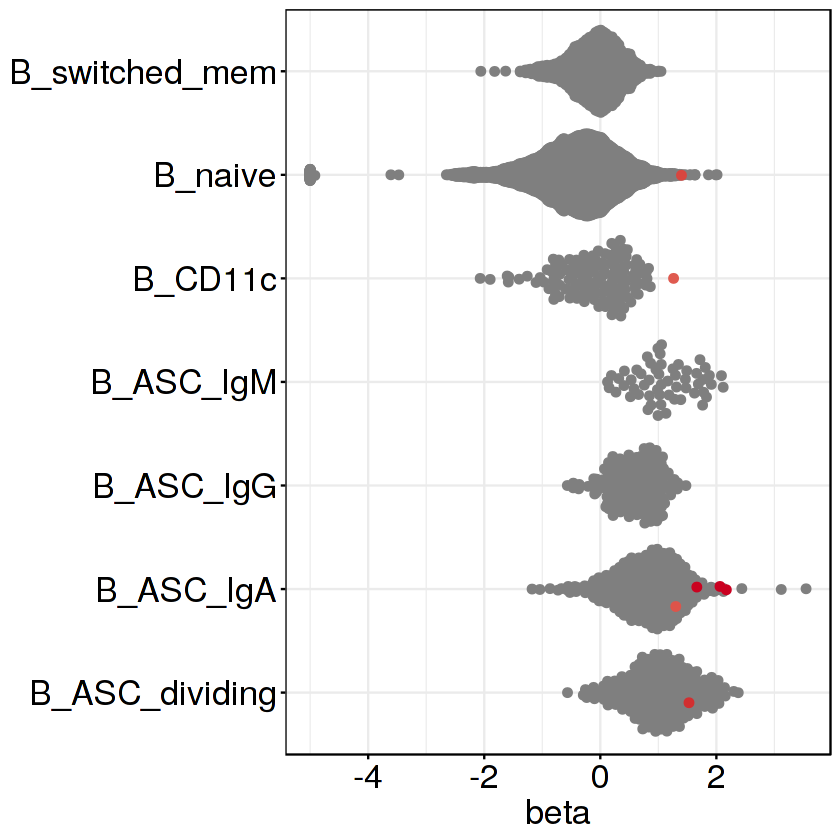

In [18]:
# options(repr.plot.width=20, repr.plot.height=10)
da.res <- annotateNhoods(mylo, da.res, coldata_col = "celltype_B_corrected")
da.res$celltype_B_corrected <- ifelse(da.res$celltype_B_corrected_fraction < 0.7, "Mixed", da.res$celltype_B_corrected)
p <- new_DA_beeswarm(da.res, color.by = 'SpatialFDR', group.by = "celltype_B_corrected", size = 2, alpha = .05)
p

Converting group.by to factor...



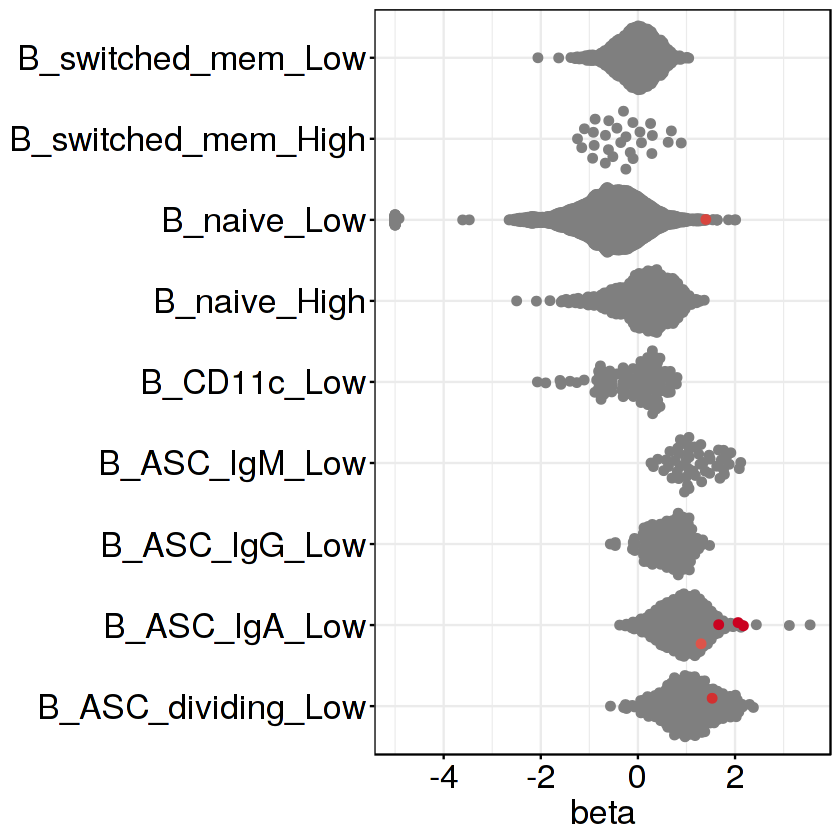

In [19]:
# options(repr.plot.width=20, repr.plot.height=10)
da.res <- annotateNhoods(mylo, da.res, coldata_col = "celltype_B_corrected_IFN")
da.res$celltype_B_corrected_IFN <- ifelse(da.res$celltype_B_corrected_IFN_fraction < 0.7, "Mixed", da.res$celltype_B_corrected_IFN)
p <- new_DA_beeswarm(da.res, color.by = 'SpatialFDR', group.by = "celltype_B_corrected_IFN", size = 2, alpha = .05)
p